In [4]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.3 MB/s eta 0:00:0000:0100:09
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 1.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 941.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 1.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 953.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 读取数据
data_qian = pd.read_csv("merged_data_filled_qian.csv")
data_zhong = pd.read_csv("merged_data_filled_zhong.csv")
data_hou = pd.read_csv("merged_data_filled_hou.csv")

def process_data(data, look_back=1):
    # Data preprocessing code (same as before)
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['hour'] = data['date'].dt.hour
    room_encoded = pd.get_dummies(data['room'], prefix='room')
    data = pd.concat([data, room_encoded], axis=1)
    features = data[['year', 'month', 'day', 'hour', 'Value'] + list(room_encoded.columns)]
    target = data['count_1s']
    
    # Modify features to include a window of previous time steps
    look_back_data = []
    for i in range(len(features) - look_back + 1):
        t = features.iloc[i:i+look_back].values
        look_back_data.append(t)

    features = np.array(look_back_data)
    
    target = target.values[look_back-1:]  # Adjust target to align with look_back

    return features, target

# Set look_back
look_back = 24

# Data preprocessing
features_qian, target_qian = process_data(data_qian, look_back=look_back)
features_zhong, target_zhong = process_data(data_zhong, look_back=look_back)

# Merge data
features = np.concatenate((features_qian, features_zhong))
target = np.concatenate((target_qian, target_zhong))

# Reshape the features array to 2D before applying MinMaxScaler
n_samples, look_back, n_features = features.shape
features = features.reshape((n_samples, look_back * n_features))

# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Reshape the features back to 3D
scaled_features = scaled_features.reshape((n_samples, look_back, n_features))

# Define K-fold cross-validation folds
k_folds = 5  # Assume using 5-fold cross-validation

# Create KFold object and get indices
kf = KFold(n_splits=k_folds, shuffle=False)  # shuffle=False, as your data is time-ordered
fold_indices = kf.split(scaled_features)

# Lists to store evaluation metrics for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Perform K-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(fold_indices):
    X_train_fold, X_val_fold = scaled_features[train_idx], scaled_features[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]

    # Create GRU model
    model_gru = Sequential()
    model_gru.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
    model_gru.add(Dropout(0.4))
    model_gru.add(GRU(units=50))
    model_gru.add(Dropout(0.4))
    model_gru.add(Dense(units=1))
    model_gru.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model_gru.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32)
     # Save model weights after training
 

    # Make predictions on the validation set
    predicted_values_gru = model_gru.predict(X_val_fold)

    # Calculate evaluation metrics (MSE, RMSE, MAE, R2, etc.)
    mse_fold = mean_squared_error(y_val_fold, predicted_values_gru)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_val_fold, predicted_values_gru)
    r2_fold = r2_score(y_val_fold, predicted_values_gru)

    print(f'Fold {fold+1} Metrics:')
    print(f'Mean Squared Error (MSE): {mse_fold}')
    print(f'Root Mean Squared Error (RMSE): {rmse_fold}')
    print(f'Mean Absolute Error (MAE): {mae_fold}')
    print(f'R-squared (R2): {r2_fold}')

    # Store evaluation metrics for each fold
    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)
    r2_scores.append(r2_fold)
# ... [Your existing code]

# After the K-fold cross-validation loop:
model_gru.save_weights("model_weights_last_fold.h5")



# Calculate the average and standard deviation of cross-validation results
print(f'Cross-validation Metrics:')
print(f'Mean MSE: {np.mean(mse_scores)}')
print(f'Standard Deviation MSE: {np.std(mse_scores)}')
print(f'Mean RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation RMSE: {np.std(rmse_scores)}')
print(f'Mean MAE: {np.mean(mae_scores)}')
print(f'Standard Deviation MAE: {np.std(mae_scores)}')
print(f'Mean R-squared (R2): {np.mean(r2_scores)}')
print(f'Standard Deviation R-squared (R2): {np.std(r2_scores)}')

Epoch 1/100
66/66 [==============================] - 4s 17ms/step - loss: 6.3561
Epoch 2/100
66/66 [==============================] - 1s 17ms/step - loss: 5.7947
Epoch 3/100
66/66 [==============================] - 1s 15ms/step - loss: 4.4240
Epoch 4/100
66/66 [==============================] - 1s 15ms/step - loss: 3.3803
Epoch 5/100
66/66 [==============================] - 1s 17ms/step - loss: 3.3605
Epoch 6/100
66/66 [==============================] - 1s 15ms/step - loss: 3.2745
Epoch 7/100
66/66 [==============================] - 1s 15ms/step - loss: 3.2546
Epoch 8/100
66/66 [==============================] - 1s 16ms/step - loss: 3.2292
Epoch 9/100
66/66 [==============================] - 1s 15ms/step - loss: 3.1405
Epoch 10/100
66/66 [==============================] - 1s 16ms/step - loss: 3.1372
Epoch 11/100
66/66 [==============================] - 1s 16ms/step - loss: 3.2301
Epoch 12/100
66/66 [==============================] - 1s 15ms/step - loss: 3.1903
Epoch 13/100
66/66 [=====

2023-08-14 23:29:00.288937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 23:29:00.315568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 23:29:00.316775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 23:29:01.115790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100
66/66 [==============================] - 4s 14ms/step - loss: 6.3632
Epoch 2/100
66/66 [==============================] - 1s 12ms/step - loss: 5.7996
Epoch 3/100
66/66 [==============================] - 1s 12ms/step - loss: 4.5716
Epoch 4/100
66/66 [==============================] - 1s 15ms/step - loss: 3.4545
Epoch 5/100
66/66 [==============================] - 1s 17ms/step - loss: 3.5291
Epoch 6/100
66/66 [==============================] - 1s 14ms/step - loss: 3.3197
Epoch 7/100
66/66 [==============================] - 1s 14ms/step - loss: 3.2680
Epoch 8/100
66/66 [==============================] - 1s 16ms/step - loss: 3.1189
Epoch 9/100
66/66 [==============================] - 1s 14ms/step - loss: 3.2469
Epoch 10/100
66/66 [==============================] - 1s 12ms/step - loss: 3.0931
Epoch 11/100
66/66 [==============================] - 1s 13ms/step - loss: 3.1506
Epoch 12/100
66/66 [==============================] - 1s 13ms/step - loss: 3.1609
Epoch 13/100
66/66 [=====

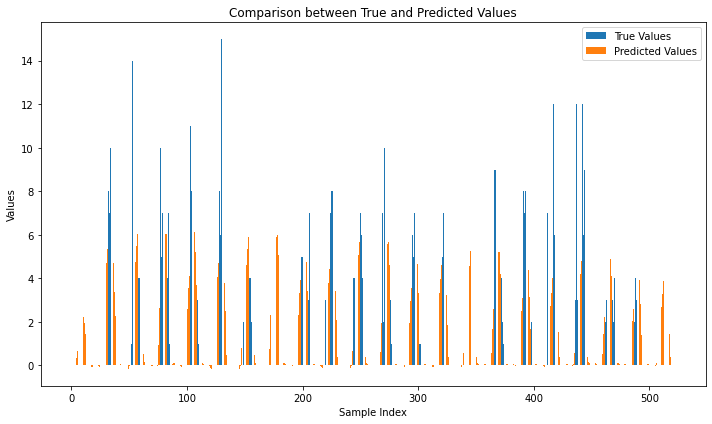

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 读取数据
data_qian = pd.read_csv("merged_data_filled_qian.csv")
data_zhong = pd.read_csv("merged_data_filled_zhong.csv")

def process_data(data, look_back=1):
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['hour'] = data['date'].dt.hour
    room_encoded = pd.get_dummies(data['room'], prefix='room')
    data = pd.concat([data, room_encoded], axis=1)
    features = data[['year', 'month', 'day', 'hour', 'Value'] + list(room_encoded.columns)]
    target = data['count_1s']

    look_back_data = []
    for i in range(len(features) - look_back + 1):
        t = features.iloc[i:i+look_back].values
        look_back_data.append(t)

    features = np.array(look_back_data)
    target = target.values[look_back-1:]

    return features, target

look_back = 24
features_qian, target_qian = process_data(data_qian, look_back=look_back)
features_zhong, target_zhong = process_data(data_zhong, look_back=look_back)
features = np.concatenate((features_qian, features_zhong))
target = np.concatenate((target_qian, target_zhong))
n_samples, look_back, n_features = features.shape
features = features.reshape((n_samples, look_back * n_features))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_features = scaled_features.reshape((n_samples, look_back, n_features))

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=False)
fold_indices = kf.split(scaled_features)

mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
accuracy_scores = []

def calculate_accuracy(y_true, y_pred, threshold=0.5):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

for fold, (train_idx, val_idx) in enumerate(fold_indices):
    X_train_fold, X_val_fold = scaled_features[train_idx], scaled_features[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]

    model_gru = Sequential()
    model_gru.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
    model_gru.add(Dropout(0.4))
    model_gru.add(GRU(units=50))
    model_gru.add(Dropout(0.4))
    model_gru.add(Dense(units=1))
    model_gru.compile(optimizer='adam', loss='mean_squared_error')
    model_gru.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32)

    predicted_values_gru = model_gru.predict(X_val_fold)

    mse_fold = mean_squared_error(y_val_fold, predicted_values_gru)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_val_fold, predicted_values_gru)
    r2_fold = r2_score(y_val_fold, predicted_values_gru)
    accuracy_fold = calculate_accuracy(y_val_fold, predicted_values_gru, threshold=0.5)

    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)
    r2_scores.append(r2_fold)
    accuracy_scores.append(accuracy_fold)

    print(f'Fold {fold+1} Metrics:')
    print(f'MSE: {mse_fold}')
    print(f'RMSE: {rmse_fold}')
    print(f'MAE: {mae_fold}')
    print(f'R2: {r2_fold}')
    print(f'Accuracy: {accuracy_fold}')

#model_gru.save_weights("model_weights_last_fold.h5")

print(f'Mean MSE: {np.mean(mse_scores)}')
print(f'Standard Deviation MSE: {np.std(mse_scores)}')
print(f'Mean RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation RMSE: {np.std(rmse_scores)}')
print(f'Mean MAE: {np.mean(mae_scores)}')
print(f'Standard Deviation MAE: {np.std(mae_scores)}')
print(f'Mean R2: {np.mean(r2_scores)}')
print(f'Standard Deviation R2: {np.std(r2_scores)}')
print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
print(f'Standard Deviation Accuracy: {np.std(accuracy_scores)}')

# 绘制柱状图比较真实数据和预测数据
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(y_val_fold))
bar_width = 0.35
rects1 = ax.bar(index, y_val_fold, bar_width, label='True Values')
rects2 = ax.bar(index + bar_width, predicted_values_gru.flatten(), bar_width, label='Predicted Values')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Values')
ax.set_title('Comparison between True and Predicted Values')
ax.legend()
plt.tight_layout()
plt.show()


In [3]:
accuracy_fold = calculate_accuracy(y_val_fold, predicted_values_gru, threshold=0.5)
print(accuracy_fold)

0.3670652837541906


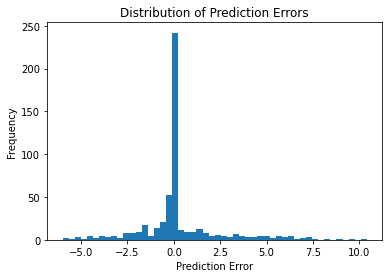

In [4]:
errors = y_val_fold - predicted_values_gru.flatten()
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()


Epoch 1/100
66/66 [==============================] - 4s 19ms/step - loss: 6.4078
Epoch 2/100
66/66 [==============================] - 1s 15ms/step - loss: 5.7912
Epoch 3/100
66/66 [==============================] - 1s 16ms/step - loss: 4.4673
Epoch 4/100
66/66 [==============================] - 1s 18ms/step - loss: 3.5248
Epoch 5/100
66/66 [==============================] - 1s 13ms/step - loss: 3.3479
Epoch 6/100
66/66 [==============================] - 1s 14ms/step - loss: 3.2294
Epoch 7/100
66/66 [==============================] - 1s 13ms/step - loss: 3.2456
Epoch 8/100
66/66 [==============================] - 1s 12ms/step - loss: 3.1530
Epoch 9/100
66/66 [==============================] - 1s 12ms/step - loss: 3.2060
Epoch 10/100
66/66 [==============================] - 1s 13ms/step - loss: 3.3182
Epoch 11/100
66/66 [==============================] - 1s 12ms/step - loss: 3.1958
Epoch 12/100
66/66 [==============================] - 1s 12ms/step - loss: 3.1475
Epoch 13/100
66/66 [=====

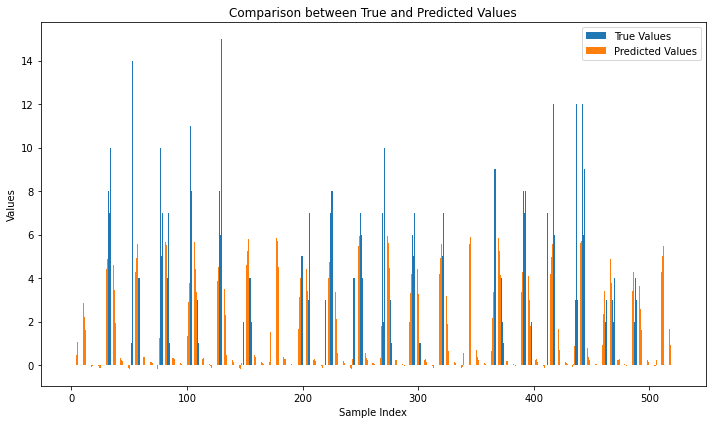

In [5]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 读取数据
data_qian = pd.read_csv("merged_data_filled_qian.csv")
data_zhong = pd.read_csv("merged_data_filled_zhong.csv")

def process_data(data, look_back=1):
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['hour'] = data['date'].dt.hour
    room_encoded = pd.get_dummies(data['room'], prefix='room')
    data = pd.concat([data, room_encoded], axis=1)
    features = data[['year', 'month', 'day', 'hour', 'Value'] + list(room_encoded.columns)]
    target = data['count_1s']

    look_back_data = []
    for i in range(len(features) - look_back + 1):
        t = features.iloc[i:i+look_back].values
        look_back_data.append(t)

    features = np.array(look_back_data)
    target = target.values[look_back-1:]

    return features, target

def calculate_accuracy(y_true, y_pred, threshold=0.5):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

look_back = 24
features_qian, target_qian = process_data(data_qian, look_back=look_back)
features_zhong, target_zhong = process_data(data_zhong, look_back=look_back)
features = np.concatenate((features_qian, features_zhong))
target = np.concatenate((target_qian, target_zhong))
n_samples, look_back, n_features = features.shape
features = features.reshape((n_samples, look_back * n_features))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_features = scaled_features.reshape((n_samples, look_back, n_features))

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=False)
fold_indices = kf.split(scaled_features)

# 累积每一次fold的结果
results = {
    "Fold": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "R2": [],
    "Accuracy within Threshold": []
}

for fold, (train_idx, val_idx) in enumerate(fold_indices):
    X_train_fold, X_val_fold = scaled_features[train_idx], scaled_features[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]

    model_gru = Sequential()
    model_gru.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
    model_gru.add(Dropout(0.4))
    model_gru.add(GRU(units=50))
    model_gru.add(Dropout(0.4))
    model_gru.add(Dense(units=1))
    model_gru.compile(optimizer='adam', loss='mean_squared_error')
    model_gru.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32)

    predicted_values_gru = model_gru.predict(X_val_fold)

    mse_fold = mean_squared_error(y_val_fold, predicted_values_gru)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_val_fold, predicted_values_gru)
    r2_fold = r2_score(y_val_fold, predicted_values_gru)
    accuracy_fold = calculate_accuracy(y_val_fold, predicted_values_gru, threshold=0.5)

    # 添加到结果字典
    results["Fold"].append(fold+1)
    results["MSE"].append(mse_fold)
    results["RMSE"].append(rmse_fold)
    results["MAE"].append(mae_fold)
    results["R2"].append(r2_fold)
    results["Accuracy within Threshold"].append(accuracy_fold)

# 使用pandas显示结果表格
results_df = pd.DataFrame(results)
print(results_df)

# 可选: 保存表格为CSV文件
# results_df.to_csv('results_table.csv', index=False)

# 绘制柱状图比较真实数据和预测数据
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(y_val_fold))
bar_width = 0.35
rects1 = ax.bar(index, y_val_fold, bar_width, label='True Values')
rects2 = ax.bar(index + bar_width, predicted_values_gru.flatten(), bar_width, label='Predicted Values')

ax.set_xlabel('Time Scale')
ax.set_ylabel('Values')
ax.set_title('Comparison between True and Predicted Values')
ax.legend()
plt.tight_layout()
plt.show()


2023-08-20 02:54:16.155476: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-20 02:54:16.193465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-20 02:54:16.194633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 02:54:17.411701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100
66/66 [==============================] - 6s 22ms/step - loss: 6.1128
Epoch 2/100
66/66 [==============================] - 1s 20ms/step - loss: 4.9083
Epoch 3/100
66/66 [==============================] - 2s 28ms/step - loss: 3.4924
Epoch 4/100
66/66 [==============================] - 2s 33ms/step - loss: 3.3595
Epoch 5/100
66/66 [==============================] - 2s 31ms/step - loss: 3.2719
Epoch 6/100
66/66 [==============================] - 2s 37ms/step - loss: 3.1831
Epoch 7/100
66/66 [==============================] - 2s 32ms/step - loss: 3.2011
Epoch 8/100
66/66 [==============================] - 2s 27ms/step - loss: 3.2185
Epoch 9/100
66/66 [==============================] - 2s 24ms/step - loss: 3.2162
Epoch 10/100
66/66 [==============================] - 2s 25ms/step - loss: 3.0822
Epoch 11/100
66/66 [==============================] - 2s 23ms/step - loss: 2.9782
Epoch 12/100
66/66 [==============================] - 2s 26ms/step - loss: 3.0967
Epoch 13/100
66/66 [=====

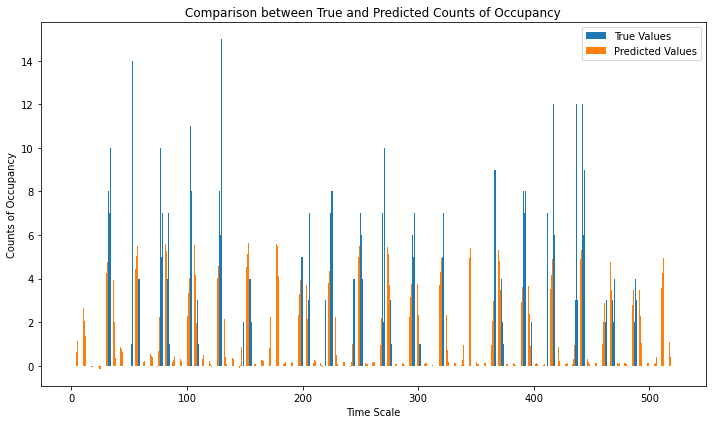

In [5]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 读取数据
data_qian = pd.read_csv("merged_data_filled_qian.csv")
data_zhong = pd.read_csv("merged_data_filled_zhong.csv")

def process_data(data, look_back=1):
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['hour'] = data['date'].dt.hour
    room_encoded = pd.get_dummies(data['room'], prefix='room')
    data = pd.concat([data, room_encoded], axis=1)
    features = data[['year', 'month', 'day', 'hour', 'Value'] + list(room_encoded.columns)]
    target = data['count_1s']

    look_back_data = []
    for i in range(len(features) - look_back + 1):
        t = features.iloc[i:i+look_back].values
        look_back_data.append(t)

    features = np.array(look_back_data)
    target = target.values[look_back-1:]

    return features, target

def calculate_accuracy(y_true, y_pred, threshold=0.5):
    return np.mean(np.abs(y_true - y_pred) <= threshold)

look_back = 24
features_qian, target_qian = process_data(data_qian, look_back=look_back)
features_zhong, target_zhong = process_data(data_zhong, look_back=look_back)
features = np.concatenate((features_qian, features_zhong))
target = np.concatenate((target_qian, target_zhong))
n_samples, look_back, n_features = features.shape
features = features.reshape((n_samples, look_back * n_features))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_features = scaled_features.reshape((n_samples, look_back, n_features))

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=False)
fold_indices = kf.split(scaled_features)

# 累积每一次fold的结果
results = {
    "Fold": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "R2": [],
    "Accuracy within Threshold": []
}

for fold, (train_idx, val_idx) in enumerate(fold_indices):
    X_train_fold, X_val_fold = scaled_features[train_idx], scaled_features[val_idx]
    y_train_fold, y_val_fold = target[train_idx], target[val_idx]

    model_gru = Sequential()
    model_gru.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
    model_gru.add(Dropout(0.4))
    model_gru.add(GRU(units=50))
    model_gru.add(Dropout(0.4))
    model_gru.add(Dense(units=1))
    model_gru.compile(optimizer='adam', loss='mean_squared_error')
    model_gru.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32)

    predicted_values_gru = model_gru.predict(X_val_fold)

    mse_fold = mean_squared_error(y_val_fold, predicted_values_gru)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_val_fold, predicted_values_gru)
    r2_fold = r2_score(y_val_fold, predicted_values_gru)
    accuracy_fold = calculate_accuracy(y_val_fold, predicted_values_gru, threshold=0.5)

    # 添加到结果字典
    results["Fold"].append(fold+1)
    results["MSE"].append(mse_fold)
    results["RMSE"].append(rmse_fold)
    results["MAE"].append(mae_fold)
    results["R2"].append(r2_fold)
    results["Accuracy within Threshold"].append(accuracy_fold)

# 使用pandas显示结果表格
results_df = pd.DataFrame(results)
print(results_df)

# 可选: 保存表格为CSV文件
results_df.to_csv('results_table_819.csv', index=False)

# 绘制柱状图比较真实数据和预测数据
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(y_val_fold))
bar_width = 0.35
rects1 = ax.bar(index, y_val_fold, bar_width, label='True Values')
rects2 = ax.bar(index + bar_width, predicted_values_gru.flatten(), bar_width, label='Predicted Values')

ax.set_xlabel('Time Scale')
ax.set_ylabel('Counts of Occupancy')
ax.set_title('Comparison between True and Predicted Counts of Occupancy')
ax.legend()
plt.tight_layout()
plt.savefig("true_vs_predicted_occupancy_comparison.png")
plt.show()

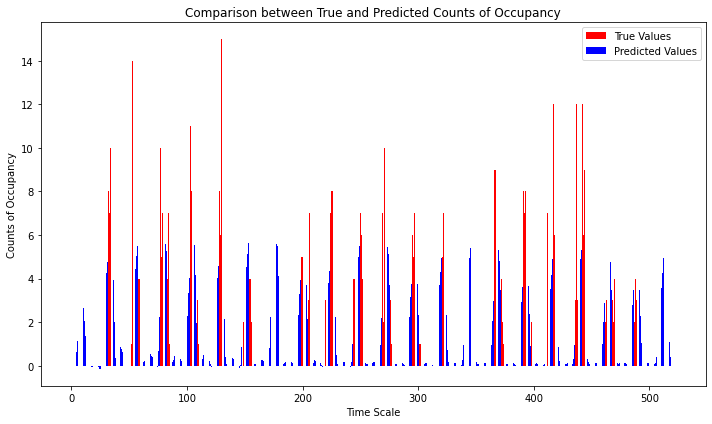

In [6]:
# ... [你原始的代码的其他部分]

# 绘制柱状图比较真实数据和预测数据
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(y_val_fold))
bar_width = 0.35
rects1 = ax.bar(index, y_val_fold, bar_width, label='True Values', color='red')  # 将真实值设置为红色
rects2 = ax.bar(index + bar_width, predicted_values_gru.flatten(), bar_width, label='Predicted Values', color='blue')  # 将预测值设置为蓝色

ax.set_xlabel('Time Scale')
ax.set_ylabel('Counts of Occupancy')
ax.set_title('Comparison between True and Predicted Counts of Occupancy')
ax.legend()

# 保存图像为PNG文件
plt.tight_layout()
plt.savefig("true_vs_predicted_occupancy_comparison.png")
plt.show()


In [35]:
def process_data(data, look_back=1, return_target=True):
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['hour'] = data['date'].dt.hour
    room_encoded = pd.get_dummies(data['room'], prefix='room')
    data = pd.concat([data, room_encoded], axis=1)
    features = data[['year', 'month', 'day', 'hour', 'Value'] + list(room_encoded.columns)]

    # Modify features to include a window of previous time steps
    look_back_data = []
    for i in range(len(features) - look_back + 1):
        t = features.iloc[i:i+look_back].values
        look_back_data.append(t)
    features = np.array(look_back_data)

    if 'count_1s' in data.columns and return_target:
        target = data['count_1s']
        target = target.values[look_back-1:]  # Adjust target to align with look_back
    else:
        target = None

    return features, target





In [36]:
# 读取数据
data_hou = pd.read_csv("merged_data_filled_hou.csv")

# 我们不需要 'count_1s' 列，因为它只是填充的0
data_hou = data_hou.drop(columns=['count_1s'])

# 预处理新数据
features_hou, _ = process_data(data_hou, look_back=look_back_prediction, return_target=False)  # 注意设置 return_target=False

# Reshape features to 2D before scaling
n_samples_hou, _, n_features_hou = features_hou.shape
features_hou_reshaped = features_hou.reshape((n_samples_hou, look_back_prediction * n_features_hou))

# 使用之前的scaler来缩放新数据
scaled_features_hou = scaler.transform(features_hou_reshaped)

# Reshape the features back to 3D
scaled_features_hou = scaled_features_hou.reshape((n_samples_hou, look_back_prediction, n_features_hou))

# 使用之前训练的模型来预测 'count_1s'
predicted_count_1s = model_gru.predict(scaled_features_hou)
print(predicted_count_1s)

# 如果您想将预测的 'count_1s' 值添加回原始数据中，可以这样操作：
#data_hou['predicted_count_1s'] = np.concatenate([np.zeros(look_back_prediction-1), predicted_count_1s.flatten()])


49/49 [==============================] - 0s 6ms/step
[[2.9712021e-02]
 [1.3542414e-02]
 [2.8309226e-04]
 ...
 [4.7853526e-01]
 [3.8649392e-01]
 [3.7591934e-01]]


In [38]:
# Assuming you have predicted_values_gru from the previous code
# Convert predicted_values_gru to a pandas DataFrame
predicted_count_1s = pd.DataFrame(predicted_count_1s, columns=['pre_count_1s'])



# Concatenate the two DataFrames side by side
result_pre = pd.concat([predicted_count_1s], axis=1)

# Save the result DataFrame to a CSV file
result_pre.to_csv("predicted_count_1s_0813.csv", index=False)

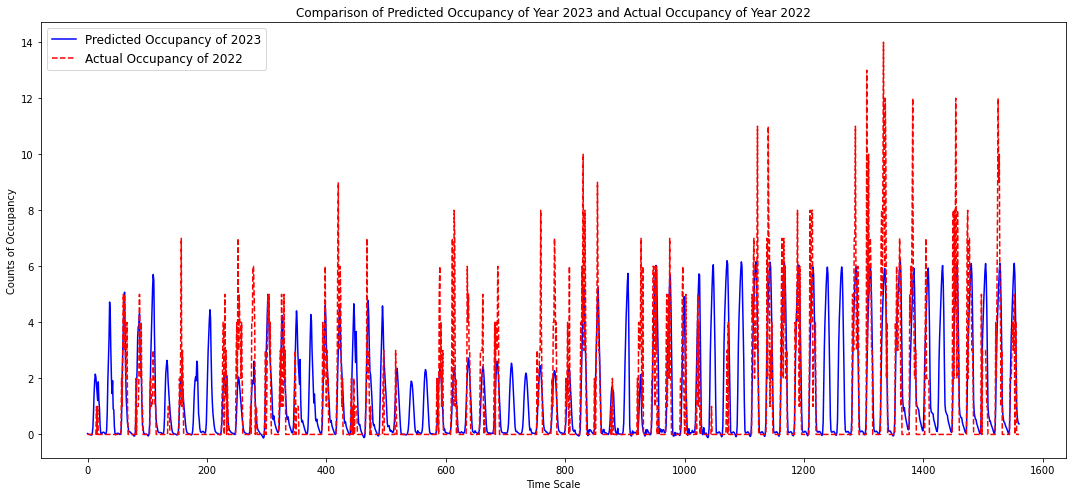

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
predicted_df = pd.read_csv("predicted_count_1s_0813.csv")
lastyear_df = pd.read_csv("grouped_hourly_counts_lastyear.csv")

# 确保两个数据框有相同的长度。如果不是，您可能需要对其进行裁剪或合并。
if len(predicted_df) != len(lastyear_df):
    print("Warning: DataFrames have different lengths!")
    min_length = min(len(predicted_df), len(lastyear_df))
    predicted_df = predicted_df.head(min_length)
    lastyear_df = lastyear_df.head(min_length)

# 画图
plt.figure(figsize=(15,7))
plt.plot(predicted_df['pre_count_1s'], label='Predicted Occupancy of 2023', color='blue')
plt.plot(lastyear_df['count_1s'], label='Actual Occupancy of 2022', color='red', linestyle='--')
plt.legend(fontsize='large') 
plt.title('Comparison of Predicted Occupancy of Year 2023 and Actual Occupancy of Year 2022')
plt.xlabel('Time Scale')
plt.ylabel('Counts of Occupancy')

plt.tight_layout()
plt.savefig("output_Comparison of Predicted Occupancy of 2023 and Actual Occupancy of 2022.png")

plt.show()


In [44]:
import tensorflow as tf

def weighted_mse(y_true, y_pred, sample_weight):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sample_weight = tf.cast(sample_weight, tf.float32)
    return tf.reduce_mean(sample_weight * tf.square(y_true - y_pred))

def tradaboost_r2(source_features, source_labels, target_features, target_labels, N=10):
    # Initialize weights
    source_weights = np.ones(source_features.shape[0]) / source_features.shape[0]
    target_weights = np.ones(target_features.shape[0]) / target_features.shape[0]
      # Modify the function call to include target_labels:
    
    
    # Create placeholders for beta values
    betas = []

    for i in range(N):
        # Train a model using source data and source weights
        model = Sequential()
        model.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
        model.add(Dropout(0.4))
        model.add(GRU(units=50))
        model.add(Dropout(0.4))
        model.add(Dense(units=1))
        
        model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_mse(y_true, y_pred, sample_weight=source_weights))
        model.fit(source_features, source_labels, epochs=10, batch_size=32)

        # Predict on target data
        target_preds = model.predict(target_features)

        # Calculate the weighted error rate
        error_rate = np.sum(target_weights * (target_preds.ravel() != target_labels))
        beta = error_rate / (1 - error_rate)
        
        # Update source weights
        source_weights *= np.exp(np.log(beta) * (source_labels != model.predict(source_features)))

        # Normalize source weights
        source_weights /= np.sum(source_weights)
        
        # Store beta
        betas.append(beta)

    return betas
# Data preprocessing for source data
features_qian, labels_qian = process_data(data_qian, look_back=look_back)
features_zhong, labels_zhong = process_data(data_zhong, look_back=look_back)

source_features = features[:-len(features_hou)]
source_labels = target[:-len(features_hou)]

# Data preprocessing for target data (without labels)
features_hou, target_hou = process_data(data_hou, look_back=look_back)
target_features = features_hou
target_labels = target_hou  # Ensure that this is the right variable for the true labels of the target dataset.

# Now you can call the TrAdaBoostR2 function
betas = tradaboost_r2(source_features, source_labels, target_features, target_labels, N=10)

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.4))
model.add(GRU(units=50))
model.add(Dropout(0.4))
model.add(Dense(units=1))

final_weights = source_weights * betas[-1]
model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_mse(y_true, y_pred, sample_weight=final_weights))
model.fit(source_features, source_labels, epochs=10, batch_size=32)

target_preds = model.predict(target_features)
print(target_preds[:5])



Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_54" is incompatible with the layer: expected shape=(None, 24, 8), found shape=(None, 192)


In [47]:
source_weights = np.ones(source_features.shape[0]) / source_features.shape[0]

def process_data(data, look_back):
    # Convert data into numpy array
    data = np.array(data)
    
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    
    X = np.array(X).reshape(-1, look_back, 1)
    Y = np.array(Y)
    
    return X, Y
look_back = 24
n_features = 1  # This assumes 'count_1s' is the only feature. Adjust if you have more features.
# 1. Define weighted_mse function
def weighted_mse(sample_weight):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        sample_weight_tensor = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
        return tf.reduce_mean(sample_weight_tensor * tf.square(y_true - y_pred))
    return loss

# ... [Process your data with process_data]

# 3. Define the model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.4))
model.add(GRU(units=50))
model.add(Dropout(0.4))
model.add(Dense(units=1))

# 4. Compile the model
model.compile(optimizer='adam', loss=weighted_mse(source_weights))

# 5. Fit the model (this will come later in your script after you've set up TrAdaBoostR2 and determined the final weights)
model.fit(source_features, source_labels, epochs=10, batch_size=32)



Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_56" is incompatible with the layer: expected shape=(None, 24, 1), found shape=(None, 192)


In [48]:
# After processing your data with process_data
print(source_features.shape)


(1057, 192)


49/49 [==============================] - 0s 4ms/step


/tmp/ipykernel_3255/233171680.py:58: RuntimeWarning: invalid value encountered in divide
  return final_preds / total_alpha


[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


49/49 [==============================] - 0s 3ms/step
[[1.22702813]
 [1.22702813]
 [1.22702813]
 ...
 [1.22702813]
 [1.22702813]
 [1.22702813]]


49/49 [==============================] - 1s 5ms/step
[[1.22371435]
 [1.22371427]
 [1.22371429]
 ...
 [1.22371433]
 [1.22371435]
 [1.22371442]]


2618
1561


(2618, 23, 8)
(1561, 23, 8)
